# SARIMA 분석
- 각 송하구-수하구 쌍별로 시계열 모델 적용
- 2024년 일별 예측치 생성
- 연평균 예측치 계산

In [10]:
# matplotlib 전역 설정을 위한 함수
def set_korean_font():
    """
    matplotlib 전역 한글 폰트 설정
    """
    plt.rc('font', family='AppleGothic')
    plt.rc('axes', unicode_minus=False)
    
    # seaborn 설정도 함께 적용
    import seaborn as sns
    sns.set(font="AppleGothic", 
           rc={"axes.unicode_minus":False},
           style='whitegrid')

# 사용 예시:
set_korean_font()

In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
daily_volume=pd.read_csv('총물동량.csv',encoding='cp949')

In [9]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 준비
daily_volume_start_end = daily_volume[['배송년월일', '송하인_구명', '수하인_구명', '총_물동량']].copy()

# 날짜 형식 변환
daily_volume_start_end['배송년월일'] = pd.to_datetime(daily_volume_start_end['배송년월일'])

def perform_sarima_analysis(data):
    """
    각 송하구-수하구 쌍에 대해 SARIMA 모델을 적용하여 2024년 예측을 수행
    """
    # 결과를 저장할 데이터프레임 준비
    future_dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
    all_predictions = []
    yearly_averages = []
    
    # 진행상황 추적을 위한 카운터
    total_pairs = len(data.groupby(['송하인_구명', '수하인_구명']))
    current_pair = 0
    
    # 모든 송하구-수하구 쌍에 대해 반복
    for (sender, receiver), group in data.groupby(['송하인_구명', '수하인_구명']):
        current_pair += 1
        print(f"Processing pair {current_pair}/{total_pairs}: {sender} -> {receiver}")
        
        # 시계열 데이터 준비
        ts = group.set_index('배송년월일')['총_물동량'].resample('D').mean().fillna(0)
        
        # 데이터가 충분한지 확인
        if len(ts) < 30:  # 최소 30일 데이터 필요
            print(f"Skipping {sender} -> {receiver}: insufficient data")
            continue
            
        try:
            # SARIMA 모델 적용
            model = SARIMAX(ts, 
                          order=(1, 1, 1),           # (p,d,q) 파라미터
                          seasonal_order=(1, 1, 1, 7),  # (P,D,Q,s) 파라미터
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            
            results = model.fit(disp=False)
            
            # 2024년 예측
            forecast = results.predict(start=future_dates[0], end=future_dates[-1])
            
            # 일별 예측 결과 저장
            for date, pred in zip(future_dates, forecast):
                all_predictions.append({
                    '배송년월일': date,
                    '송하인_구명': sender,
                    '수하인_구명': receiver,
                    '예측_물동량': max(0, pred)  # 음수 예측값 방지
                })
            
            # 연평균 예측 저장
            yearly_averages.append({
                '송하인_구명': sender,
                '수하인_구명': receiver,
                '연평균_예측_물동량': max(0, forecast.mean())  # 음수 예측값 방지
            })
            
        except Exception as e:
            print(f"Error processing {sender} -> {receiver}: {str(e)}")
            continue
    
    # 결과 데이터프레임 생성
    if all_predictions:
        daily_predictions_df = pd.DataFrame(all_predictions)
        yearly_averages_df = pd.DataFrame(yearly_averages)
        
        # 결과 저장
        daily_predictions_df.to_csv('sarima_daily_predictions_2024.csv', index=False)
        yearly_averages_df.to_csv('sarima_yearly_averages_2024.csv', index=False)
        
        # 상위 10개 경로의 예측 결과 시각화
        plt.figure(figsize=(15, 8))
        top_10_routes = yearly_averages_df.nlargest(10, '연평균_예측_물동량')
        
        sns.barplot(data=top_10_routes, 
                    x='연평균_예측_물동량', 
                    y=top_10_routes.apply(lambda x: f"{x['송하인_구명']} -> {x['수하인_구명']}", axis=1))
        
        plt.title('2024년 예측 물동량 상위 10개 경로')
        plt.xlabel('연평균 예측 물동량')
        plt.ylabel('물류 경로')
        plt.tight_layout()
        plt.savefig('top_10_routes_2024.png')
        plt.close()
        
        return daily_predictions_df, yearly_averages_df
    else:
        print("No successful predictions were made.")
        return None, None

# SARIMA 분석 실행
print("Starting SARIMA analysis...")
daily_predictions, yearly_averages = perform_sarima_analysis(daily_volume_start_end)

# 결과 출력
if yearly_averages is not None:
    print("\n===== 연평균 예측 물동량 상위 10개 경로 =====")
    top_10 = yearly_averages.nlargest(10, '연평균_예측_물동량')
    print(top_10)
    print("\nAnalysis complete. Results have been saved to CSV files.")

Starting SARIMA analysis...
Processing pair 1/625: 강남구 -> 강남구
Processing pair 2/625: 강남구 -> 강동구
Processing pair 3/625: 강남구 -> 강북구
Processing pair 4/625: 강남구 -> 강서구
Processing pair 5/625: 강남구 -> 관악구
Processing pair 6/625: 강남구 -> 광진구
Processing pair 7/625: 강남구 -> 구로구
Processing pair 8/625: 강남구 -> 금천구
Processing pair 9/625: 강남구 -> 노원구
Processing pair 10/625: 강남구 -> 도봉구
Processing pair 11/625: 강남구 -> 동대문구
Processing pair 12/625: 강남구 -> 동작구
Processing pair 13/625: 강남구 -> 마포구
Processing pair 14/625: 강남구 -> 서대문구
Processing pair 15/625: 강남구 -> 서초구
Processing pair 16/625: 강남구 -> 성동구
Processing pair 17/625: 강남구 -> 성북구
Processing pair 18/625: 강남구 -> 송파구
Processing pair 19/625: 강남구 -> 양천구
Processing pair 20/625: 강남구 -> 영등포구
Processing pair 21/625: 강남구 -> 용산구
Processing pair 22/625: 강남구 -> 은평구
Processing pair 23/625: 강남구 -> 종로구
Processing pair 24/625: 강남구 -> 중구
Processing pair 25/625: 강남구 -> 중랑구
Processing pair 26/625: 강동구 -> 강남구
Processing pair 27/625: 강동구 -> 강동구
Processing pair 28/625: 강동구 -> 강북구

/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processing pair 355/625: 서초구 -> 관악구
Processing pair 356/625: 서초구 -> 광진구
Processing pair 357/625: 서초구 -> 구로구
Processing pair 358/625: 서초구 -> 금천구
Processing pair 359/625: 서초구 -> 노원구
Processing pair 360/625: 서초구 -> 도봉구
Processing pair 361/625: 서초구 -> 동대문구
Processing pair 362/625: 서초구 -> 동작구
Processing pair 363/625: 서초구 -> 마포구
Processing pair 364/625: 서초구 -> 서대문구
Processing pair 365/625: 서초구 -> 서초구
Processing pair 366/625: 서초구 -> 성동구
Processing pair 367/625: 서초구 -> 성북구
Processing pair 368/625: 서초구 -> 송파구
Processing pair 369/625: 서초구 -> 양천구
Processing pair 370/625: 서초구 -> 영등포구
Processing pair 371/625: 서초구 -> 용산구
Processing pair 372/625: 서초구 -> 은평구
Processing pair 373/625: 서초구 -> 종로구
Processing pair 374/625: 서초구 -> 중구
Processing pair 375/625: 서초구 -> 중랑구
Processing pair 376/625: 성동구 -> 강남구
Processing pair 377/625: 성동구 -> 강동구
Processing pair 378/625: 성동구 -> 강북구
Processing pair 379/625: 성동구 -> 강서구
Processing pair 380/625: 성동구 -> 관악구
Processing pair 381/625: 성동구 -> 광진구
Processing pair 382/625: 성

/var/folders/bf/v7jnwl4x1318f88y9y2nlss40000gn/T/ipykernel_62025/3312746079.py:93: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bf/v7jnwl4x1318f88y9y2nlss40000gn/T/ipykernel_62025/3312746079.py:93: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bf/v7jnwl4x1318f88y9y2nlss40000gn/T/ipykernel_62025/3312746079.py:93: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bf/v7jnwl4x1318f88y9y2nlss40000gn/T/ipykernel_62025/3312746079.py:93: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bf/v7jnwl4x1318f88y9y2nlss40000gn/T/ipykernel_62025/3312746079.py:93: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bf/v7jnwl4x1318f88y9y2nlss40000gn/T/i

# GNN 기반 분석을 위한 데이터 준비

- 노드(구) 특성 준비
- 엣지(물동량) 특성 준비
- PyTorch Geometric 등의 라이브러리와 함께 사용 가능

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import tqdm

class GNN(nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv3(x, edge_index, edge_weight)
        return x

def prepare_gnn_data(data):
    print(f"전체 데이터 크기: {len(data)}")
    
    # 날짜 변환
    data['배송년월일'] = pd.to_datetime(data['배송년월일'])
    data['요일'] = data['배송년월일'].dt.dayofweek
    data['월'] = data['배송년월일'].dt.month
    
    # 일자별 집계
    daily_agg = data.groupby(['배송년월일', '송하인_구명', '수하인_구명'])['총_물동량'].sum().reset_index()
    print(f"일자별 집계 후 데이터 크기: {len(daily_agg)}")
    
    # 노드(구) 특성 준비
    unique_districts = pd.concat([data['송하인_구명'], data['수하인_구명']]).unique()
    district_to_idx = {district: idx for idx, district in enumerate(unique_districts)}
    
    # 노드 특성 생성
    node_features = []
    for district in unique_districts:
        # 발송 특성
        sent_volume = data[data['송하인_구명'] == district]['총_물동량'].mean()
        sent_freq = len(data[data['송하인_구명'] == district])
        
        # 수신 특성
        received_volume = data[data['수하인_구명'] == district]['총_물동량'].mean()
        received_freq = len(data[data['수하인_구명'] == district])
        
        # 시간적 특성
        weekday_volume = data[data['요일'].isin([0,1,2,3,4]) & 
                            ((data['송하인_구명'] == district) | 
                             (data['수하인_구명'] == district))]['총_물동량'].mean()
        
        weekend_volume = data[data['요일'].isin([5,6]) & 
                            ((data['송하인_구명'] == district) | 
                             (data['수하인_구명'] == district))]['총_물동량'].mean()
        
        node_features.append([
            sent_volume, sent_freq, 
            received_volume, received_freq,
            weekday_volume, weekend_volume
        ])
    
    # 엣지 데이터 준비
    edges = []
    edge_weights = []
    
    for _, row in daily_agg.iterrows():
        i = district_to_idx[row['송하인_구명']]
        j = district_to_idx[row['수하인_구명']]
        
        edges.append([i, j])
        edge_weights.append(row['총_물동량'])
    
    # PyTorch Geometric 데이터 형식으로 변환
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(edge_weights, dtype=torch.float)
    node_features = torch.tensor(node_features, dtype=torch.float)
    
    data = Data(
        x=node_features,
        edge_index=edge_index,
        edge_weight=edge_weight
    )
    
    return data, district_to_idx, unique_districts

def train_gnn_model(data, epochs=100):
    print(f"노드 특성 크기: {data.x.size()}")
    print(f"엣지 수: {data.edge_index.size(1)}")
    
    model = GNN(num_features=data.x.size(1), hidden_channels=32)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    # 학습 진행률 표시
    pbar = tqdm.tqdm(range(epochs), desc='Training GNN')
    losses = []
    
    model.train()
    start_time = time()
    
    for epoch in pbar:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_weight)
        
        target = data.edge_weight.view(-1, 1)
        loss = F.mse_loss(out[data.edge_index[0]], target)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        pbar.set_postfix({'loss': loss.item()})
    
    training_time = time() - start_time
    print(f"\n학습 완료. 총 소요시간: {training_time:.2f}초")
    
    # 손실 그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('학습 과정에서의 손실 변화')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('gnn_training_loss.png')
    plt.close()
    
    return model, losses

def predict_and_evaluate(model, data, district_to_idx, unique_districts):
    model.eval()
    with torch.no_grad():
        predictions = model(data.x, data.edge_index, data.edge_weight)
    
    # 예측 결과를 데이터프레임으로 변환
    results = []
    idx_to_district = {v: k for k, v in district_to_idx.items()}
    
    for i in range(len(unique_districts)):
        for j in range(len(unique_districts)):
            if i != j:
                results.append({
                    '송하인_구명': idx_to_district[i],
                    '수하인_구명': idx_to_district[j],
                    '예측_물동량': float(predictions[i])
                })
    
    results_df = pd.DataFrame(results)
    
    # 결과 저장
    results_df.to_csv('gnn_predictions.csv', index=False)
    
    # 상위 10개 경로 시각화
    plt.figure(figsize=(15, 8))
    top_10 = results_df.nlargest(10, '예측_물동량')
    
    sns.barplot(data=top_10,
                x='예측_물동량',
                y=top_10.apply(lambda x: f"{x['송하인_구명']} -> {x['수하인_구명']}", axis=1))
    
    plt.title('GNN 예측 물동량 상위 10개 경로')
    plt.xlabel('예측 물동량')
    plt.ylabel('물류 경로')
    plt.tight_layout()
    plt.savefig('gnn_top_10_routes.png')
    plt.close()
    
    return results_df

def run_gnn_analysis(daily_volume):
    print("데이터 전처리 시작...")
    data, district_to_idx, unique_districts = prepare_gnn_data(daily_volume)
    
    print("\nGNN 모델 학습 시작...")
    model, losses = train_gnn_model(data, epochs=100)
    
    print("\n예측 및 평가 중...")
    predictions_df = predict_and_evaluate(model, data, district_to_idx, unique_districts)
    
    return predictions_df, losses

# 실행
print("GNN 분석 시작...")
start_time = time()
predictions_df, losses = run_gnn_analysis(daily_volume_start_end)
total_time = time() - start_time

print(f"\n전체 프로세스 소요시간: {total_time:.2f}초")
print("\n=== 예측 물동량 상위 10개 경로 ===")
print(predictions_df.nlargest(10, '예측_물동량'))

GNN 분석 시작...
데이터 전처리 시작...
전체 데이터 크기: 1260417
일자별 집계 후 데이터 크기: 1260417

GNN 모델 학습 시작...
노드 특성 크기: torch.Size([25, 6])
엣지 수: 1260417


Training GNN: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s, loss=3.65e+5]



학습 완료. 총 소요시간: 27.94초

예측 및 평가 중...

전체 프로세스 소요시간: 67.22초

=== 예측 물동량 상위 10개 경로 ===
  송하인_구명 수하인_구명       예측_물동량
0    강남구    강동구  1483.067993
1    강남구    강북구  1483.067993
2    강남구    강서구  1483.067993
3    강남구    관악구  1483.067993
4    강남구    광진구  1483.067993
5    강남구    구로구  1483.067993
6    강남구    금천구  1483.067993
7    강남구    노원구  1483.067993
8    강남구   동대문구  1483.067993
9    강남구    마포구  1483.067993


# OD 행렬 기반 다익스트라 분석
- 물동량의 역수를 가중치로 사용
- 최단경로 분석 가능
- 클러스터 간 효율적인 물류 경로 도출

- 중심성 지표
연결 중심성 (in/out degree)
매개 중심성
근접 중심성
고유벡터 중심성

- 발송/수신 패턴 유사도
- 클러스터별 구 수와 구성

OD 분석 시작...
1. OD 벡터 및 행렬 생성 중...
2. 클러스터링 수행 중...
3. 가중 네트워크 생성 중...
4. 최단경로 분석 중...
5. 결과 시각화 중...


/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: 


=== 클러스터별 특성 ===
       구  클러스터
0    강남구     2
1    강동구     4
2    강북구     0
3    강서구     1
4    관악구     4
5    광진구     4
6    구로구     4
7    금천구     3
8    노원구     4
9    도봉구     0
10  동대문구     4
11   동작구     4
12   마포구     1
13  서대문구     0
14   서초구     1
15   성동구     3
16   성북구     3
17   송파구     1
18   양천구     4
19  영등포구     4
20   용산구     3
21   은평구     4
22   종로구     0
23    중구     3
24   중랑구     0

=== 주요 최적 경로 ===
     출발_클러스터  도착_클러스터  출발지  도착지          경로       경로_길이     총_물동량
360        3        2  성북구  강남구  성북구 -> 강남구  139.692879  0.007159
449        3        1  성북구  송파구  성북구 -> 송파구  158.493192  0.006309
18         2        1  강남구  송파구  강남구 -> 송파구  162.292347  0.006162
446        3        1  성북구  강서구  성북구 -> 강서구  180.263344  0.005547
17         2        1  강남구  서초구  강남구 -> 서초구  184.829815  0.005410


/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/jeong-yujin/Library/Python/

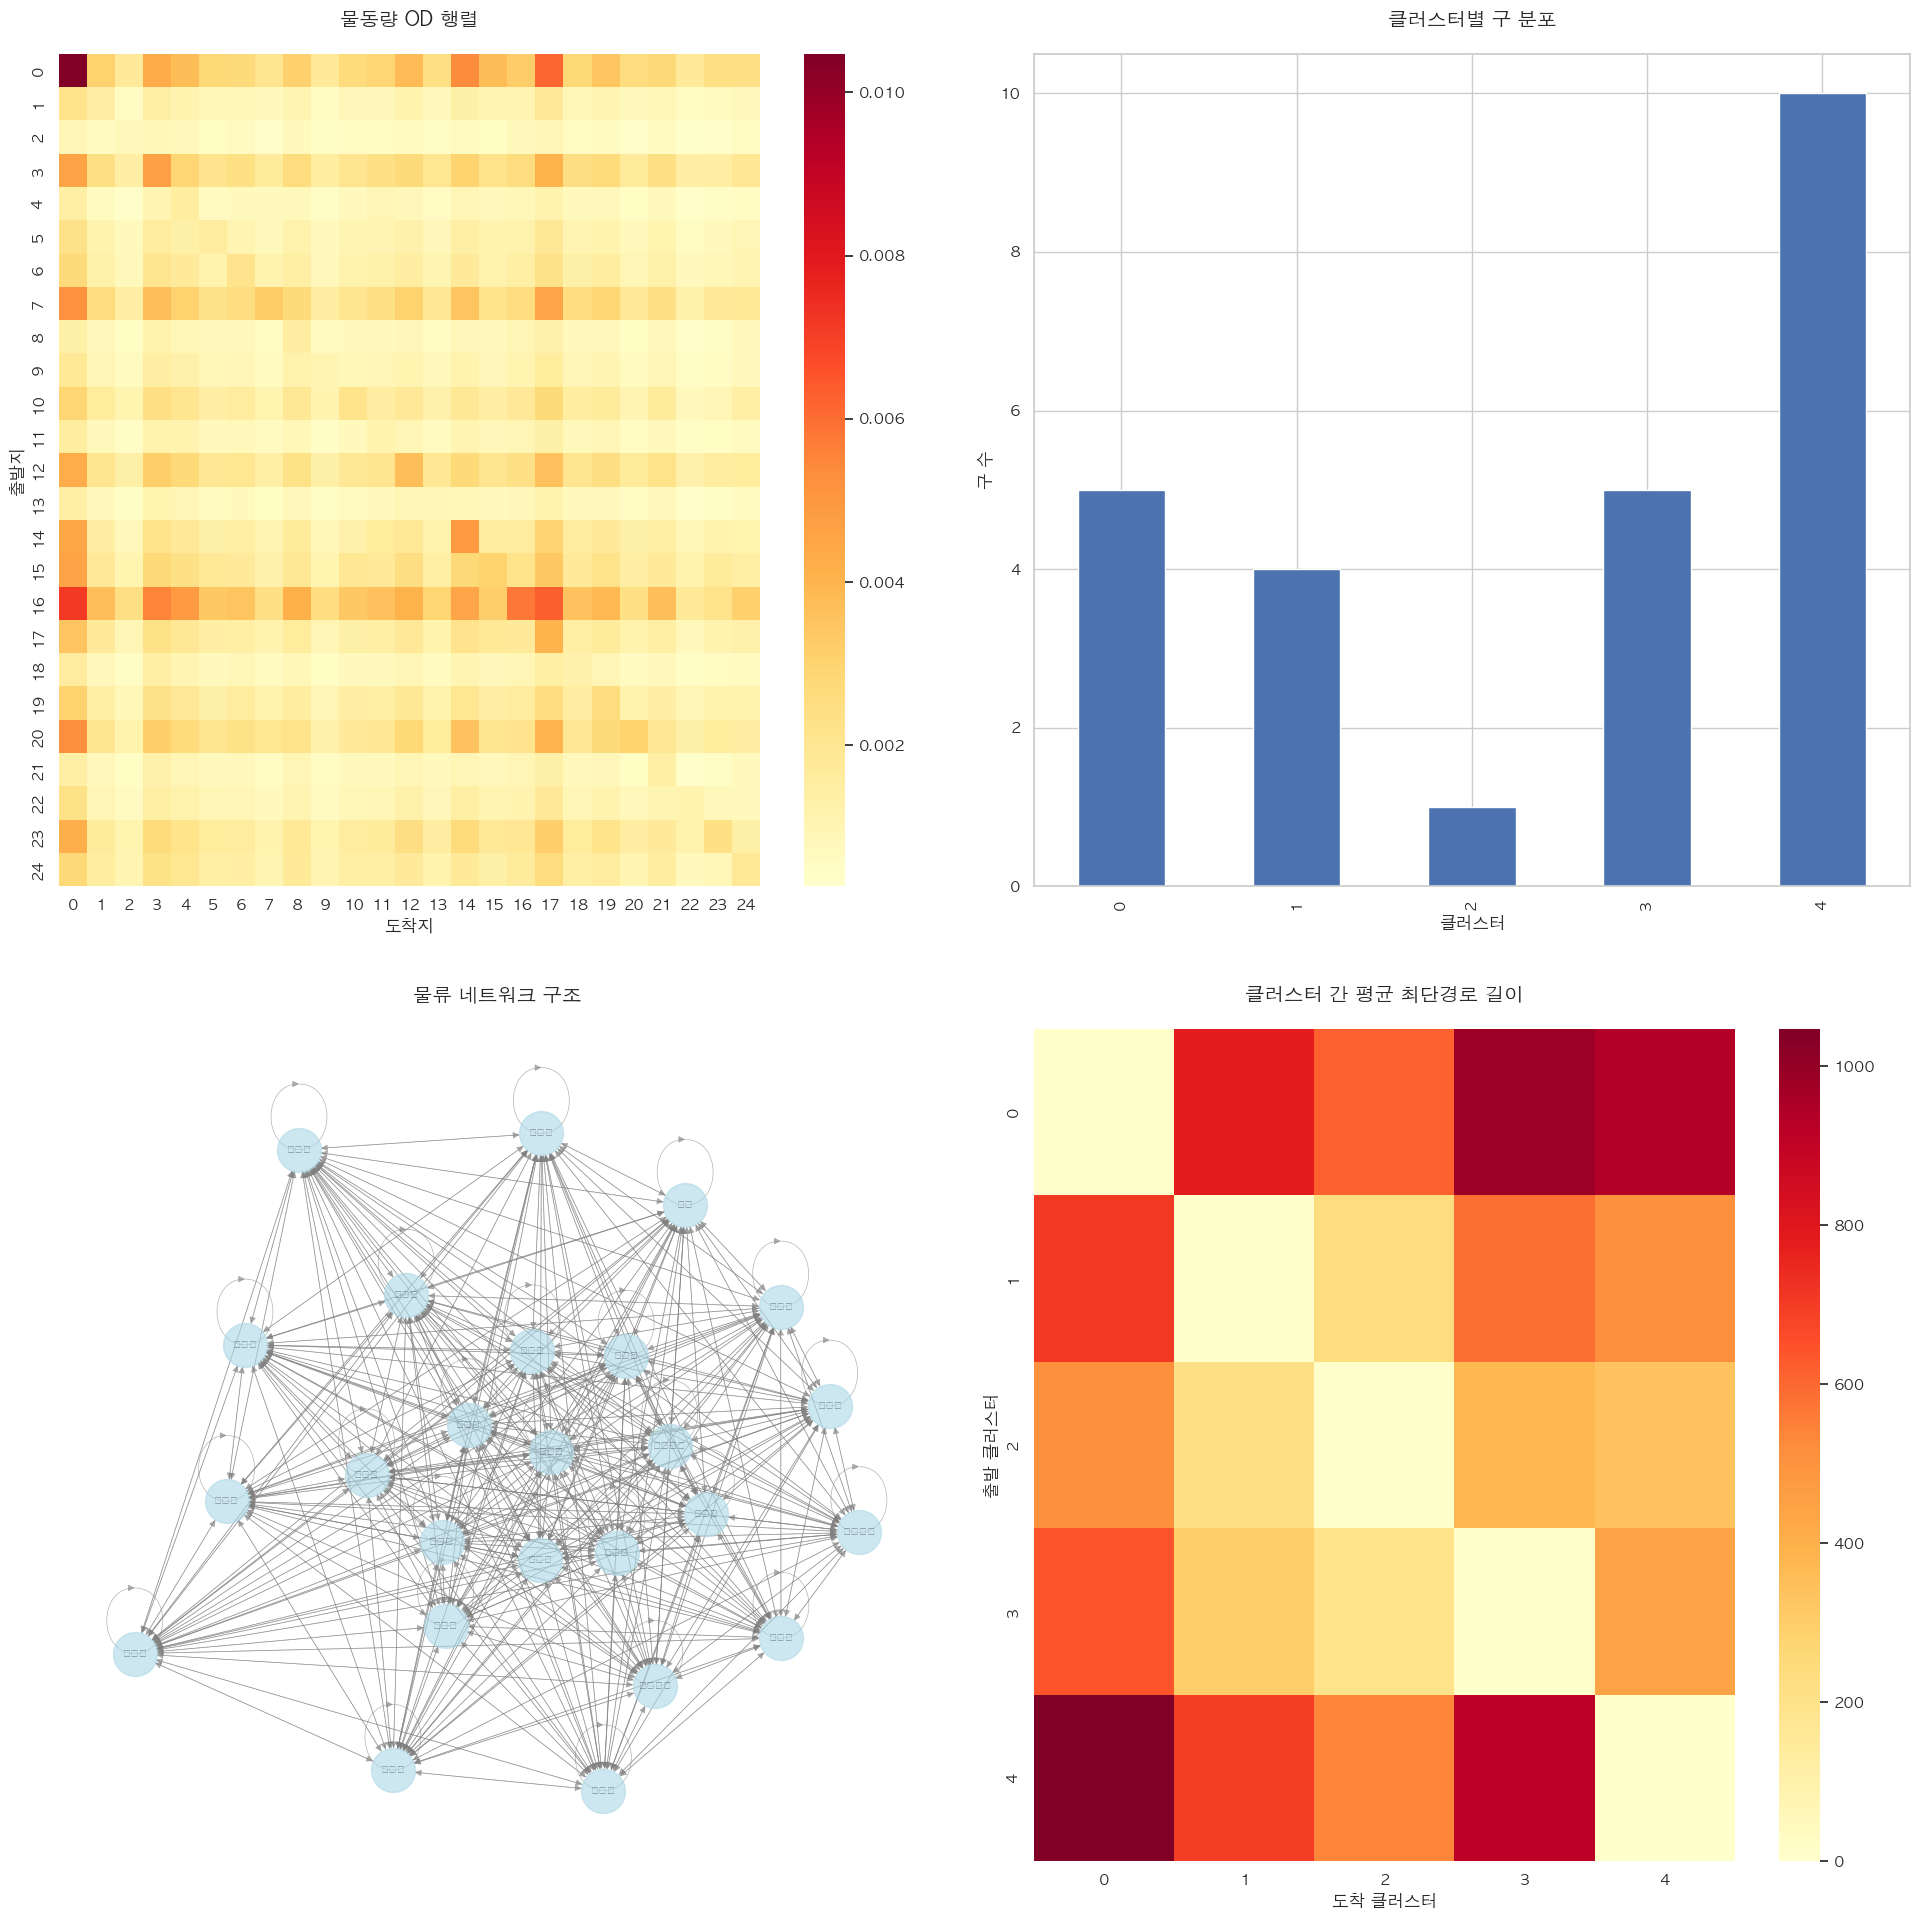

In [18]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def create_od_vectors(daily_volume):
    """
    구별 OD 동선벡터 생성
    
    Returns:
    --------
    od_vectors : DataFrame
        구별 OD 패턴 벡터
    od_matrix : ndarray
        평균 OD 행렬
    """
    districts = sorted(list(set(daily_volume['송하인_구명'].unique()) | 
                          set(daily_volume['수하인_구명'].unique())))
    n_districts = len(districts)
    district_to_idx = {district: idx for idx, district in enumerate(districts)}
    
    od_matrix = np.zeros((n_districts, n_districts))
    
    for _, row in daily_volume.iterrows():
        i = district_to_idx[row['송하인_구명']]
        j = district_to_idx[row['수하인_구명']]
        od_matrix[i][j] += row['총_물동량']
    
    od_matrix = od_matrix / od_matrix.sum()
    od_vectors = pd.DataFrame(index=districts)
    
    for i, district in enumerate(districts):
        od_vectors[f'{district}_발송'] = od_matrix[i, :]
    
    for i, district in enumerate(districts):
        od_vectors[f'{district}_수신'] = od_matrix[:, i]
    
    return od_vectors, od_matrix, districts

def cluster_districts(od_vectors, n_clusters=5):
    """
    구별 OD 패턴 클러스터링
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(od_vectors)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    
    cluster_results = pd.DataFrame({
        '구': od_vectors.index,
        '클러스터': clusters
    })
    
    return cluster_results, kmeans.cluster_centers_

def create_weighted_graph(od_matrix, districts):
    """
    가중 그래프 생성
    """
    G = nx.DiGraph()
    
    for district in districts:
        G.add_node(district)
    
    n_districts = len(districts)
    for i in range(n_districts):
        for j in range(n_districts):
            if od_matrix[i,j] > 0:
                weight = 1 / od_matrix[i,j]
                G.add_edge(districts[i], districts[j], 
                          weight=weight,
                          volume=od_matrix[i,j])
    
    return G

def analyze_shortest_paths(G, cluster_results):
    """
    클러스터 간 최단경로 분석
    """
    paths_analysis = []
    
    clusters = cluster_results['클러스터'].unique()
    for c1 in clusters:
        for c2 in clusters:
            if c1 != c2:
                districts1 = cluster_results[cluster_results['클러스터'] == c1]['구']
                districts2 = cluster_results[cluster_results['클러스터'] == c2]['구']
                
                for d1 in districts1:
                    for d2 in districts2:
                        try:
                            path = nx.shortest_path(G, d1, d2, weight='weight')
                            length = nx.shortest_path_length(G, d1, d2, weight='weight')
                            
                            # 경로 상의 총 물동량 계산
                            total_volume = sum(G[path[i]][path[i+1]]['volume'] 
                                            for i in range(len(path)-1))
                            
                            paths_analysis.append({
                                '출발_클러스터': c1,
                                '도착_클러스터': c2,
                                '출발지': d1,
                                '도착지': d2,
                                '경로': ' -> '.join(path),
                                '경로_길이': length,
                                '총_물동량': total_volume
                            })
                        except nx.NetworkXNoPath:
                            continue
    
    return pd.DataFrame(paths_analysis)

def visualize_results(od_matrix, cluster_results, G, districts):
    """
    분석 결과 시각화
    """
    plt.figure(figsize=(20, 20))
    
    # 1. OD 행렬 히트맵
    ax1 = plt.subplot(2, 2, 1)
    sns.heatmap(od_matrix, ax=ax1, cmap='YlOrRd')
    ax1.set_title('물동량 OD 행렬', pad=20, fontsize=14)
    ax1.set_xlabel('도착지', fontsize=12)
    ax1.set_ylabel('출발지', fontsize=12)
    
    # 2. 클러스터링 결과
    ax2 = plt.subplot(2, 2, 2)
    cluster_counts = cluster_results['클러스터'].value_counts().sort_index()
    cluster_counts.plot(kind='bar', ax=ax2)
    ax2.set_title('클러스터별 구 분포', pad=20, fontsize=14)
    ax2.set_xlabel('클러스터', fontsize=12)
    ax2.set_ylabel('구 수', fontsize=12)
    
    # 3. 네트워크 그래프
    ax3 = plt.subplot(2, 2, 3)
    pos = nx.spring_layout(G, k=1.5, iterations=50)
    nx.draw(G, pos, ax=ax3, 
            node_color='lightblue',
            node_size=1000,
            font_size=8,
            font_weight='bold',
            width=0.5,
            edge_color='gray',
            alpha=0.6,
            with_labels=True)
    ax3.set_title('물류 네트워크 구조', pad=20, fontsize=14)
    
    # 4. 클러스터 간 평균 최단경로 길이
    ax4 = plt.subplot(2, 2, 4)
    n_clusters = len(cluster_results['클러스터'].unique())
    cluster_distances = np.zeros((n_clusters, n_clusters))
    
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i != j:
                districts1 = cluster_results[cluster_results['클러스터'] == i]['구']
                districts2 = cluster_results[cluster_results['클러스터'] == j]['구']
                
                distances = []
                for d1 in districts1:
                    for d2 in districts2:
                        try:
                            dist = nx.shortest_path_length(G, d1, d2, weight='weight')
                            distances.append(dist)
                        except nx.NetworkXNoPath:
                            continue
                
                if distances:
                    cluster_distances[i][j] = np.mean(distances)
    
    sns.heatmap(cluster_distances, ax=ax4, cmap='YlOrRd')
    ax4.set_title('클러스터 간 평균 최단경로 길이', pad=20, fontsize=14)
    ax4.set_xlabel('도착 클러스터', fontsize=12)
    ax4.set_ylabel('출발 클러스터', fontsize=12)
    
    plt.tight_layout(pad=3.0)
    return plt.gcf()

def create_and_analyze_network(daily_volume, n_clusters=5):
    """
    전체 분석 프로세스 실행
    """
    print("1. OD 벡터 및 행렬 생성 중...")
    od_vectors, od_matrix, districts = create_od_vectors(daily_volume)
    
    print("2. 클러스터링 수행 중...")
    cluster_results, cluster_centers = cluster_districts(od_vectors, n_clusters)
    
    print("3. 가중 네트워크 생성 중...")
    G = create_weighted_graph(od_matrix, districts)
    
    print("4. 최단경로 분석 중...")
    paths_df = analyze_shortest_paths(G, cluster_results)
    
    print("5. 결과 시각화 중...")
    fig = visualize_results(od_matrix, cluster_results, G, districts)
    
    # 결과 저장
    od_vectors.to_csv('od_vectors.csv')
    cluster_results.to_csv('cluster_results.csv')
    paths_df.to_csv('optimal_paths.csv')
    fig.savefig('od_analysis_results.png', dpi=300, bbox_inches='tight')
    
    return {
        'od_vectors': od_vectors,
        'cluster_results': cluster_results,
        'paths_df': paths_df,
        'network': G
    }

# 분석 실행
print("OD 분석 시작...")
results = create_and_analyze_network(daily_volume_start_end, n_clusters=5)

print("\n=== 클러스터별 특성 ===")
print(results['cluster_results'])

print("\n=== 주요 최적 경로 ===")
print(results['paths_df'].nsmallest(5, '경로_길이'))

In [19]:
# 기존 OD 분석 결과 시각화 수정
def visualize_results(od_matrix, cluster_results, G, districts):
    plt.figure(figsize=(20, 15))
    
    # 1. OD 행렬 히트맵 (4.1.2 OD 행렬 분석 결과에 배치)
    ax1 = plt.subplot(2, 2, 1)
    sns.heatmap(od_matrix, ax=ax1, cmap='YlOrRd')
    ax1.set_title('구별 물동량 OD 행렬', pad=20, fontsize=14)
    ax1.set_xlabel('도착지', fontsize=12)
    ax1.set_ylabel('출발지', fontsize=12)
    
    # 2. 상위 10개 구 물동량 막대그래프 (4.1.1 모델 성능 평가에 배치)
    ax2 = plt.subplot(2, 2, 2)
    district_volumes = od_matrix.sum(axis=1)  # 각 구의 총 물동량 계산
    top_districts = pd.Series(district_volumes, index=districts).nlargest(10)
    
    sns.barplot(x=top_districts.values, y=top_districts.index, ax=ax2, 
                palette='YlOrRd')
    ax2.set_title('상위 10개 구 일평균 물동량', pad=20, fontsize=14)
    ax2.set_xlabel('물동량', fontsize=12)
    ax2.set_ylabel('구', fontsize=12)
    
    # 3. 네트워크 그래프 (4.2.1 최적 노선 선정에 배치)
    ax3 = plt.subplot(2, 2, 3)
    pos = nx.spring_layout(G, k=1.5, iterations=50)
    
    # 노드 크기를 물동량에 비례하게 설정
    node_sizes = [G.degree(node) * 100 for node in G.nodes()]
    
    nx.draw(G, pos, ax=ax3,
            node_color='lightblue',
            node_size=node_sizes,
            font_size=8,
            font_weight='bold',
            width=0.5,
            edge_color='gray',
            alpha=0.6,
            with_labels=True)
    ax3.set_title('구별 물류 네트워크 구조', pad=20, fontsize=14)
    
    # 4. 클러스터별 평균 물동량 막대그래프 (4.2.2 네트워크 효율성 검증에 배치)
    ax4 = plt.subplot(2, 2, 4)
    cluster_volumes = cluster_results.merge(
        pd.DataFrame({'구': districts, '물동량': district_volumes}),
        on='구'
    ).groupby('클러스터')['물동량'].mean()
    
    sns.barplot(x=cluster_volumes.index, y=cluster_volumes.values, ax=ax4,
                palette='YlOrRd')
    ax4.set_title('클러스터별 평균 물동량', pad=20, fontsize=14)
    ax4.set_xlabel('클러스터', fontsize=12)
    ax4.set_ylabel('평균 물동량', fontsize=12)
    
    plt.tight_layout(pad=3.0)
    return plt.gcf()

# 2. SARIMA 예측 결과 시각화 추가
def visualize_predictions(daily_predictions, yearly_averages):
    plt.figure(figsize=(15, 10))
    
    # 1. 상위 10개 경로 연평균 예측 물동량
    ax1 = plt.subplot(2, 1, 1)
    top_10_routes = yearly_averages.nlargest(10, '연평균_예측_물동량')
    routes = top_10_routes.apply(
        lambda x: f"{x['송하인_구명']} → {x['수하인_구명']}", axis=1
    )
    
    sns.barplot(x=top_10_routes['연평균_예측_물동량'], y=routes, ax=ax1,
                palette='YlOrRd')
    ax1.set_title('2024년 예측 물동량 상위 10개 경로', pad=20, fontsize=14)
    ax1.set_xlabel('연평균 예측 물동량', fontsize=12)
    ax1.set_ylabel('물류 경로', fontsize=12)
    
    # 2. 구별 총 예측 물동량
    ax2 = plt.subplot(2, 1, 2)
    district_volumes = yearly_averages.groupby('송하인_구명')['연평균_예측_물동량'].sum()
    top_districts = district_volumes.nlargest(10)
    
    sns.barplot(x=top_districts.values, y=top_districts.index, ax=ax2,
                palette='YlOrRd')
    ax2.set_title('2024년 구별 예측 총 물동량 상위 10개', pad=20, fontsize=14)
    ax2.set_xlabel('예측 총 물동량', fontsize=12)
    ax2.set_ylabel('구', fontsize=12)
    
    plt.tight_layout(pad=3.0)
    return plt.gcf()

In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 결과 저장을 위한 디렉토리 생성
def create_result_directory():
    # real 폴더 생성
    real_dir = Path("real")
    real_dir.mkdir(exist_ok=True)
    return real_dir

def save_visualizations(od_matrix, cluster_results, G, districts, daily_predictions, yearly_averages, save_dir):
    # 1. 상위 10개 구 물동량
    plt.figure(figsize=(12, 6))
    district_volumes = od_matrix.sum(axis=1)
    top_districts = pd.Series(district_volumes, index=districts).nlargest(10)
    
    sns.barplot(x=top_districts.values, y=top_districts.index, palette='YlOrRd')
    plt.title('상위 10개 구 일평균 물동량', pad=20, fontsize=14)
    plt.xlabel('물동량', fontsize=12)
    plt.ylabel('구', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_dir / 'top_10_districts.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 2. OD 행렬 히트맵
    plt.figure(figsize=(12, 10))
    sns.heatmap(od_matrix, cmap='YlOrRd')
    plt.title('구별 물동량 OD 행렬', pad=20, fontsize=14)
    plt.xlabel('도착지', fontsize=12)
    plt.ylabel('출발지', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_dir / 'od_matrix_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 3. 네트워크 그래프
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=1.5, iterations=50)
    node_sizes = [G.degree(node) * 100 for node in G.nodes()]
    
    nx.draw(G, pos,
            node_color='lightblue',
            node_size=node_sizes,
            font_size=8,
            font_weight='bold',
            width=0.5,
            edge_color='gray',
            alpha=0.6,
            with_labels=True)
    plt.title('구별 물류 네트워크 구조', pad=20, fontsize=14)
    plt.tight_layout()
    plt.savefig(save_dir / 'network_structure.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 4. 클러스터별 평균 물동량
    plt.figure(figsize=(10, 6))
    cluster_volumes = cluster_results.merge(
        pd.DataFrame({'구': districts, '물동량': district_volumes}),
        on='구'
    ).groupby('클러스터')['물동량'].mean()
    
    sns.barplot(x=cluster_volumes.index, y=cluster_volumes.values, palette='YlOrRd')
    plt.title('클러스터별 평균 물동량', pad=20, fontsize=14)
    plt.xlabel('클러스터', fontsize=12)
    plt.ylabel('평균 물동량', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_dir / 'cluster_volumes.png', dpi=300, bbox_inches='tight')
    plt.close()

    # SARIMA 결과 시각화
    if yearly_averages is not None:
        plt.figure(figsize=(12, 6))
        top_10_routes = yearly_averages.nlargest(10, '연평균_예측_물동량')
        routes = top_10_routes.apply(
            lambda x: f"{x['송하인_구명']} → {x['수하인_구명']}", axis=1
        )
        
        sns.barplot(x=top_10_routes['연평균_예측_물동량'], y=routes, palette='YlOrRd')
        plt.title('2024년 예측 물동량 상위 10개 경로', pad=20, fontsize=14)
        plt.xlabel('연평균 예측 물동량', fontsize=12)
        plt.ylabel('물류 경로', fontsize=12)
        plt.tight_layout()
        plt.savefig(save_dir / 'top_10_routes_prediction.png', dpi=300, bbox_inches='tight')
        plt.close()

# 메인 실행 함수
def main():
    # 디렉토리 생성
    save_dir = create_result_directory()
    
    # 기존 분석 결과 불러오기
    results = create_and_analyze_network(daily_volume_start_end, n_clusters=5)
    
    # SARIMA 분석 실행
    daily_predictions, yearly_averages = perform_sarima_analysis(daily_volume_start_end)
    
    # 시각화 및 저장
    save_visualizations(
        results['od_matrix'],
        results['cluster_results'],
        results['network'],
        results['districts'],
        daily_predictions,
        yearly_averages,
        save_dir
    )
    
    print(f"모든 시각화가 {save_dir} 폴더에 저장되었습니다.")

if __name__ == "__main__":
    main()

1. OD 벡터 및 행렬 생성 중...
2. 클러스터링 수행 중...
3. 가중 네트워크 생성 중...
4. 최단경로 분석 중...
5. 결과 시각화 중...


/var/folders/bf/v7jnwl4x1318f88y9y2nlss40000gn/T/ipykernel_62025/2322771990.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_districts.values, y=top_districts.index, ax=ax2,
/var/folders/bf/v7jnwl4x1318f88y9y2nlss40000gn/T/ipykernel_62025/2322771990.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_volumes.index, y=cluster_volumes.values, ax=ax4,
/var/folders/bf/v7jnwl4x1318f88y9y2nlss40000gn/T/ipykernel_62025/2330970693.py:206: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) Arial.
  fig.savefig('od_analysis_results.png', dpi=300, bbox_inches='tight')
/var/folders/bf/v7jnwl4x1318f88y9y2nlss40000gn/T/ipykernel_62025/2330970693.py:206: UserWar

Processing pair 1/625: 강남구 -> 강남구
Processing pair 2/625: 강남구 -> 강동구
Processing pair 3/625: 강남구 -> 강북구
Processing pair 4/625: 강남구 -> 강서구
Processing pair 5/625: 강남구 -> 관악구
Processing pair 6/625: 강남구 -> 광진구
Processing pair 7/625: 강남구 -> 구로구
Processing pair 8/625: 강남구 -> 금천구
Processing pair 9/625: 강남구 -> 노원구
Processing pair 10/625: 강남구 -> 도봉구
Processing pair 11/625: 강남구 -> 동대문구
Processing pair 12/625: 강남구 -> 동작구
Processing pair 13/625: 강남구 -> 마포구
Processing pair 14/625: 강남구 -> 서대문구
Processing pair 15/625: 강남구 -> 서초구
Processing pair 16/625: 강남구 -> 성동구
Processing pair 17/625: 강남구 -> 성북구
Processing pair 18/625: 강남구 -> 송파구
Processing pair 19/625: 강남구 -> 양천구
Processing pair 20/625: 강남구 -> 영등포구
Processing pair 21/625: 강남구 -> 용산구
Processing pair 22/625: 강남구 -> 은평구
Processing pair 23/625: 강남구 -> 종로구
Processing pair 24/625: 강남구 -> 중구
Processing pair 25/625: 강남구 -> 중랑구
Processing pair 26/625: 강동구 -> 강남구
Processing pair 27/625: 강동구 -> 강동구
Processing pair 28/625: 강동구 -> 강북구
Processing pair 29/625: 강동구

/Users/jeong-yujin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processing pair 355/625: 서초구 -> 관악구
Processing pair 356/625: 서초구 -> 광진구
Processing pair 357/625: 서초구 -> 구로구
Processing pair 358/625: 서초구 -> 금천구
Processing pair 359/625: 서초구 -> 노원구
Processing pair 360/625: 서초구 -> 도봉구
Processing pair 361/625: 서초구 -> 동대문구
Processing pair 362/625: 서초구 -> 동작구
Processing pair 363/625: 서초구 -> 마포구
Processing pair 364/625: 서초구 -> 서대문구
Processing pair 365/625: 서초구 -> 서초구
Processing pair 366/625: 서초구 -> 성동구
Processing pair 367/625: 서초구 -> 성북구
Processing pair 368/625: 서초구 -> 송파구
Processing pair 369/625: 서초구 -> 양천구
Processing pair 370/625: 서초구 -> 영등포구
Processing pair 371/625: 서초구 -> 용산구
Processing pair 372/625: 서초구 -> 은평구
Processing pair 373/625: 서초구 -> 종로구
Processing pair 374/625: 서초구 -> 중구
Processing pair 375/625: 서초구 -> 중랑구
Processing pair 376/625: 성동구 -> 강남구
Processing pair 377/625: 성동구 -> 강동구
Processing pair 378/625: 성동구 -> 강북구
Processing pair 379/625: 성동구 -> 강서구
Processing pair 380/625: 성동구 -> 관악구
Processing pair 381/625: 성동구 -> 광진구
Processing pair 382/625: 성